# '1997-2005' Model

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data
df = pd.read_csv('extracted_big.csv')

## Final Data Prep

### Split and Scale

In [2]:
# set X test and train
mask = df['race_id']<5500
X_train = df[mask].drop(['result','won'],axis=1)
X_test = df[~mask].drop(['result','won'],axis=1).reset_index(drop=True)

# set y test and train
y = 'result' # or 'won'
y_train = df.loc[mask,y]
y_test = df.loc[~mask,y].reset_index(drop=True)

# display split
split = pd.DataFrame()
split['n'] = [X_train.shape[0],X_test.shape[0]]
split['%'] = [X_train.shape[0]/df.shape[0],X_test.shape[0]/df.shape[0]]
split.rename(index={0:'Train',1:'Test'})

,n,%
Train,68021,0.898441
Test,7689,0.101559


In [3]:
# load scale library
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scale data
scale = ['horse_age', 'horse_rating', 'declared_weight','actual_weight', 'draw', 'win_odds', 
         'place_odds', 'distance','race_class', 'temprature', 'race_count', 'days_since_race', 'recent_result', 
         'average_result', 'recent_lengths_behind', 'average_lengths_behind', 'recent_normal_speed',
         'average_normal_speed', 'recent_race_class','average_race_class', 'recent_draw', 'average_draw',
         'recent_actual_weight', 'average_actual_weight', 'distance_pref', 'surface_pref', 
         'going_pref', 'venue_pref', 'recent_jockey_prof','average_jockey_prof', 'recent_trainer_perf', 
         'average_trainer_perf', 'recent_jockey_skill', 'average_jockey_skill']

# initiate scalar
#scaler = StandardScaler()
scaler = MinMaxScaler()

# fit and transform sets
scaler.fit(X_train[scale])
X_train[scale] = scaler.transform(X_train[scale])
X_test[scale] = scaler.transform(X_test[scale])

# save and remove 'race_id'
race_id_train = X_train['race_id']
race_id_test = X_test['race_id']
X_train = X_train.drop('race_id',axis=1)
X_test = X_test.drop('race_id',axis=1)

X_train.head()

,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,surface,distance,race_class,...,config_C+3,going_GOOD,going_GOOD TO FIRM,going_GOOD TO YIELDING,going_SLOW,going_SOFT,going_WET FAST,going_WET SLOW,going_YIELDING,going_YIELDING TO SOFT
0,0.142857,0.378151,0.483728,1.000000,0.428571,0.088776,0.030337,0,0.285714,0.384615,...,0,0,1,0,0,0,0,0,0,0
1,0.142857,0.378151,0.424556,1.000000,0.785714,0.153061,0.043820,0,0.285714,0.384615,...,0,0,1,0,0,0,0,0,0,0
2,0.142857,0.378151,0.575444,0.966667,0.500000,0.025510,0.005618,0,0.285714,0.384615,...,0,0,1,0,0,0,0,0,0,0
3,0.142857,0.378151,0.628698,0.800000,0.857143,0.387755,0.112360,0,0.285714,0.384615,...,0,0,1,0,0,0,0,0,0,0
4,0.142857,0.378151,0.412722,0.933333,0.928571,0.500000,0.146067,0,0.285714,0.384615,...,0,0,1,0,0,0,0,0,0,0


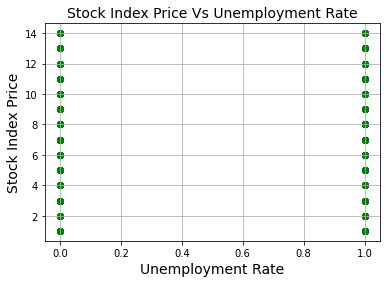

In [8]:
plt.scatter(df['horse_country_AUS'], df['result'], color='green')
plt.title('Stock Index Price Vs Unemployment Rate', fontsize=14)
plt.xlabel('Unemployment Rate', fontsize=14)
plt.ylabel('Stock Index Price', fontsize=14)
plt.grid(True)
plt.show()

## Feature Selection

#### Accuracy Function

In [4]:
# define true positive acuracy for 1st place function
def p_accuracy(y_hat,y_true):
    y_hat_1 = y_hat == 1
    y_1 = y_true == 1
    y_0 = y_true == 0
    tp = np.mean(y_hat_1 & y_1)
    fp = np.mean(y_hat_1 & y_0)
    return tp, fp

#### Best Parameters for Model with 'Won' Target
 - logistic: class_weight='balanced', C=1, solver='saga', penalty='l2'
 - decision tree: ctiterion='entropy', class_weight='none'
 
#### Best Parameters for Model with 'Result' Target
 - logistic: class_weight='balanced', C=10, solver='saga', penalty='l2'
 - decision tree: ctiterion='entropy', class_weight='none'

#### Embedded Method: Lasso Regulation

In [5]:
# load libraries
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# define parameters and structures
alphas=10**np.linspace(1,-2,100)*0.5
tps = []
fps = []
lcoef = []
R2 = []

# find best alpha
for alpha in alphas:
    
    # run lasso for each alpha
    lasso = Lasso(alpha=alpha, copy_X=True, random_state=42, max_iter=100000)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    tp, fp = p_accuracy(y_pred, y_test)
    tps += [tp]
    fps += [fp]
    lcoef += [lasso.coef_.tolist()]
    R2 += [r2_score(y_test, y_pred)]

Best Lasso
Alpha: 0.005
R2   : 0.264
TP   : 0.0
FP   : 0.0


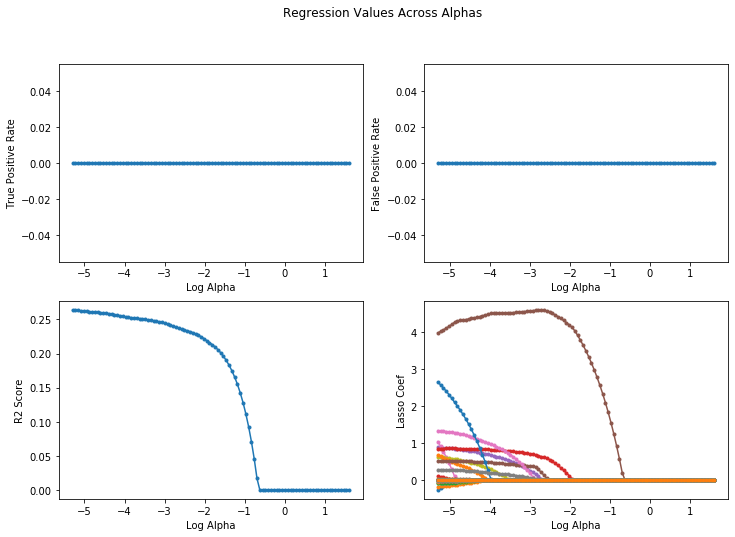

In [6]:
# output best alpha and R2
TP = pd.Series(tps)
R2 = pd.Series(R2)
FP = pd.Series(fps)
idxmax = R2.idxmax()
print('Best Lasso\nAlpha:', alphas[idxmax])
print('R2   :',round(R2[idxmax],3))
print('TP   :',round(TP[idxmax],3))
print('FP   :',round(FP[idxmax],3))

# plot R2 and Coef
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2,figsize=(12,8))
fig.suptitle('Regression Values Across Alphas')

ax1.plot(np.log(alphas), TP, '.-')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('Log Alpha')

ax2.plot(np.log(alphas), FP, '.-')
ax2.set_ylabel('False Positive Rate')
ax2.set_xlabel('Log Alpha')

ax3.plot(np.log(alphas), R2, '.-')
ax3.set_ylabel('R2 Score')
ax3.set_xlabel('Log Alpha')

ax4.plot(np.log(alphas), lcoef, '.-')
ax4.set_ylabel('Lasso Coef')
ax4.set_xlabel('Log Alpha')

plt.show()

In [7]:
# store best
lasso = Lasso(alpha=alphas[idxmax], copy_X=True, random_state=42, max_iter=100000)
lasso.fit(X_train, y_train)

# set lasso X test and train
coef = lasso.coef_ > 0
X_train_lasso = X_train.iloc[:,coef]
X_test_lasso = X_test.iloc[:,coef].reset_index(drop=True)

# show non-zero coeff
print('# non-zero coef:', len(coef[coef == True]))
X_train_lasso.head()

# non-zero coef: 14


,actual_weight,draw,win_odds,place_odds,surface,distance,race_count,recent_result,distance_pref,surface_pref,average_jockey_prof,recent_trainer_perf,horse_country_AUS,venue_ST
0,0.700000,0.285714,0.265306,0.083146,0,0.428571,0.0,0.769231,0.769231,0.769231,0.526627,0.230769,0,1
1,0.500000,0.071429,0.091837,0.020225,0,0.428571,0.0,0.461538,0.461538,0.461538,0.576923,0.615385,1,1
2,0.766667,0.857143,0.036735,0.010112,0,0.285714,0.0,0.153846,0.153846,0.153846,0.393162,0.538462,1,1
3,0.933333,0.214286,0.084694,0.014607,0,0.571429,0.0,0.384615,0.384615,0.384615,0.454849,0.538462,0,0
4,0.666667,0.285714,0.034694,0.006742,0,0.571429,0.0,0.769231,0.769231,0.769231,0.520147,0.692308,0,0


#### Wrapper Methods: Stepwise Forward and Backwards Exlusion (RFE) 

C:\Users\shanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\shanc\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


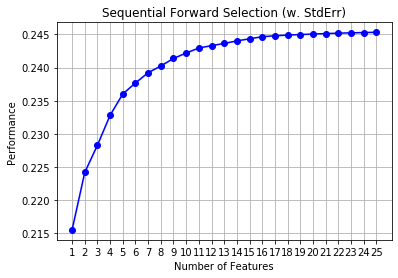

In [8]:
# import feature selection libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Sequential Forward Selection (sfs) with R2 as evaluator
# using LinearRegression for speed
sfs = SFS(LinearRegression(), k_features=25, forward=True, floating=False, scoring = 'r2', cv = 0)
sfs.fit(X_train, y_train)

# plot to find best # of feature to select
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [9]:
# save selected features to X test & train
coef = sfs.k_feature_names_[0:17]
X_train_forward = X_train.loc[:,coef]
X_test_forward = X_test.loc[:,coef].reset_index(drop=True)

# show selected features
print('# selected features:', len(coef))
X_train_forward.head()

# selected features: 17


,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,distance,race_count,days_since_race,recent_result,average_normal_speed,recent_race_class,recent_draw,distance_pref,surface_pref,going_pref
0,0.142857,0.378151,0.650888,0.700000,0.285714,0.265306,0.083146,0.428571,0.0,0.002737,0.769231,0.292431,0.307692,0.857143,0.769231,0.769231,0.769231
1,0.142857,0.378151,0.535503,0.500000,0.071429,0.091837,0.020225,0.428571,0.0,0.000912,0.461538,0.350537,0.307692,0.071429,0.461538,0.461538,0.461538
2,0.142857,0.378151,0.692308,0.766667,0.857143,0.036735,0.010112,0.285714,0.0,0.002737,0.153846,0.195348,0.384615,0.714286,0.153846,0.153846,0.153846
3,0.142857,0.378151,0.582840,0.933333,0.214286,0.084694,0.014607,0.571429,0.0,0.003650,0.384615,0.350178,0.307692,0.785714,0.384615,0.384615,0.384615
4,0.142857,0.378151,0.647929,0.666667,0.285714,0.034694,0.006742,0.571429,0.0,0.005474,0.769231,0.273634,0.307692,0.785714,0.769231,0.769231,0.769231


In [ ]:
# import feature selection libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Sequential Forward Selection (sfs) with R2 as evaluator
logit = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
sfs1 = SFS(logit, k_features=25, forward=True, floating=False, scoring = 'r2', cv = 0)
sfs1.fit(X_train, y_train)

# plot to find best # of feature to select
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
# save selected features to X test & train
coef = sfs1.k_feature_names_[0:10]
sfs_train = X_train.loc[:,coef]
sfs_test = X_test.loc[:,coef].reset_index(drop=True)

# show selected features
print('# selected features:', len(coef))
sfs_test.head()

#### RFE

In [ ]:
# import feature selection libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# run recursive feature elimination
estimator = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
rfe = RFE(estimator, n_features_to_select=18, step=1) #18 is best for rfe
rfe = rfe.fit(X_train, y_train)

In [ ]:
# get test and train
cols = rfe.support_
rfe_train = X_train.loc[:,cols]
rfe_test = X_test.loc[:,cols]
test_pred = rfe.estimator_.predict(rfe_test)
train_acc = round(rfe.estimator_.score(rfe_train, y_train),4)
test_acc = round(rfe.estimator_.score(rfe_test, y_test),4)
r2 = round(r2_score(y_test, test_pred),4)
print('RFE Results')
print('Number Features:',18)
print('Train Accuracy:',train_acc)
print('Test Accuracy:',test_acc)
print('R2 Score:',r2)

rfe_train.head()

#### PCA Method

Min PC to Explain 80% Variance: 16
% Explained: 80.08


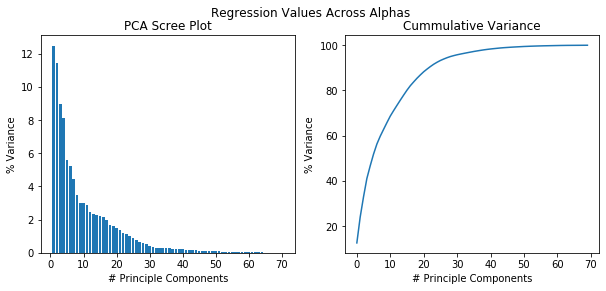

In [227]:
# load PCA libraries
from sklearn.decomposition import PCA

# run PCA
pca_70 = PCA(n_components=70)
pc70_train = pd.DataFrame(pca_70.fit_transform(X_train))
pc70_test = pd.DataFrame(pca_70.transform(X_test))

# find desired size (80% of variance)
percent_variance = np.round(pca_70.explained_variance_ratio_*100, decimals=2)
cum_variance = []
cum = 0
for i in percent_variance:
    cum += i
    cum_variance += [cum]
    
# get # of PC to explain 80% of variance
cum_variance = pd.Series(cum_variance)
idxmin = cum_variance[cum_variance >= 80].idxmin()
print('Min PC to Explain 80% Variance:',idxmin+1)
print('% Explained:', cum_variance[idxmin])

# split into PC_small = pc15 test and train data
pc15_train = pc70_train.iloc[:,0:idxmin]
pc15_test = pc70_test.iloc[:,0:idxmin]

# plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Regression Values Across Alphas')

ax1.bar(x= range(1,71), height=percent_variance)
ax1.set_title('PCA Scree Plot')
ax1.set_ylabel('% Variance')
ax1.set_xlabel('# Principle Components')

ax2.plot(cum_variance)
ax2.set_title('Cummulative Variance')
ax2.set_ylabel('% Variance')
ax2.set_xlabel('# Principle Components')

plt.show()

In [ ]:
# output features for quick hard coding
print('Forward (linear):\n',X_train_forward.columns.values)
print('Forward (logit):\n',sfs_train.columns.values)
print('RFE:\n',rfe_train.columns.values)

## Model Exploration: Simple Models 

Selected features: complete, lasso, forward, RFE, PCA 70, PCA 15

In [ ]:
# select what models to run
knn_key = False
lin_key = False
logit_key = True
dt_key = True
bagging_key = False

# select what selections to run
lasso_key = False
f_key = True
f2_key = False
rfe_key = False
pc_key = True

### kNN

In [ ]:
# load knn library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

def get_best_knn(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if knn_key == False or key == False:
        return np.nan, np.nan, np.nan, np.nan
    
    # run knn model
    test_error = []
    train_error = []
    r2 = []
    for n in range(2,20):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        pred_test = knn.predict(X_test)
        pred_train = knn.predict(X_train)
        train_error.append(np.mean(pred_train != y_train))
        test_error.append(np.mean(pred_test != y_test))
        r2.append(r2_score(y_test, pred_test))

    # plot knn error
    error = pd.DataFrame([test_error, train_error], index=['Test','Train']).T
    error.plot(figsize=(12,4))
    plt.title('Error Rate Over K Value')
    plt.xlabel('K Value')
    plt.ylabel('Error')
    plt.show()
    
    # out best errors
    train_error = pd.Series(train_error)
    r2 = pd.Series(r2)
    min_test = min(test_error)
    train_acc = 1 - round(train_error[test_error == min_test].values[0],4)
    k = train_error[test_error == min_test].index[0]
    r2 = round(r2[test_error == min_test].values[0],4)
    test_acc = 1- round((min_test,4))
    
    return test_acc, train_acc, k, r2

In [ ]:
# get best kNN on complete set
test_acc, train_acc, k, r2 = get_best_knn(X_train,X_test,y_train,y_test)

In [ ]:
# get best kNN on lasso set
test_acc_l, train_acc_l, k_l, r2_l = get_best_knn(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)

In [ ]:
# get best kNN on forward (linear) set
test_acc_f, train_acc_f, k_f, r2_f = get_best_knn(X_train_forward,X_test_forward,y_train,y_test)

In [ ]:
# get best kNN on forward (logit) set
test_acc_f2, train_acc_f2, k_f2, r2_f2 = get_best_knn(sfs_train,sfs_test,y_train,y_test,f2_key)

In [ ]:
# get best kNN on RFE set
test_acc_rfe, train_acc_rfe, k_rfe, r2_rfe = get_best_knn(rfe_train,rfe_test,y_train,y_test,rfe_key)

In [ ]:
# get best kNN on PC_70 set
test_acc_70, train_acc_70, k_70, r2_70 = get_best_knn(pc70_train,pc70_test,y_train,y_test)

In [ ]:
# get best kNN on PC_15 set
test_acc_15, train_acc_15, k_15, r2_15 = get_best_knn(pc15_train,pc15_test,y_train,y_test)

In [ ]:
# output kNN results
out = pd.DataFrame()
out['Complete'] = [k, test_acc, train_acc, r2]
out['Lasso'] = [k_l, test_acc_l, train_acc_l, r2_l]
out['Forward'] = [k_f, test_acc_f, train_acc_f, r2_f]
out['Forward 2'] = [k_f2, test_acc_f2, train_acc_f2, r2_f2]
out['RFE'] = [k_rfe, test_acc_rfe, train_acc_rfe, r2_rfe]
out['PC_70'] = [k_70, test_acc_70, train_acc_70, r2_70]
out['PC_15'] = [k_15, test_acc_15, train_acc_15, r2_15]
out.rename(index={0:'k value',1:'Train Accuracy',2:'Test Accuracy',3:'R2 Score'})

In [ ]:
# best model knn
'''k = 2
X = X_train
y = y_train
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y)'''

### Linear Regression

In [221]:
# load regression library
from sklearn.linear_model import LinearRegression

# define regression function
def get_linearReg(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if lin_key == False or key == False:
        return np.nan, np.nan, np.nan, np.nan
    
    # run model
    lin = LinearRegression()
    lin.fit(X_train,y_train)
    
    # calc results
    pred_train = round(pd.Series(lin.predict(X_train)))
    pred_test = round(pd.Series(lin.predict(X_test)))
    train_acc = round(np.mean(pred_train == y_train),4)
    test_acc = round(np.mean(pred_test == y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(pred_test, y_test)
    
    return lin, [train_acc, test_acc, r2, tp, fp]

In [222]:
# output regression results
out = pd.DataFrame()

# get best regression on complete, lasso, forward, rfe, pc_70, and pc_16 sets
lin_c, out['Complete']  = get_linearReg(X_train,X_test,y_train,y_test)
lin_l, out['Lasso'] = get_linearReg(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)
lin_f, out['Forward'] = get_linearReg(X_train_forward,X_test_forward,y_train,y_test)
lin_f2, out['Forward 2'] = get_linearReg(sfs_train,sfs_test,y_train,y_test, f2_key)
lin_rfe, out['RFE'] = get_linearReg(rfe_train, rfe_test, y_train, y_test,rfe_key)
lin_70, out['PC_70']  = get_linearReg(pc70_train,pc70_test,y_train,y_test)
lin_15, out['PC_15'] = get_linearReg(pc15_train,pc15_test,y_train,y_test)
out = out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

out

,Complete
Train Accuracy,0.1023
Test Accuracy,0.1108
R2 Score,0.2559
TP Rate,0.0000
FP Rate,0.0000


### Logistic Regression

In [163]:
# load logit library
from sklearn.linear_model import LogisticRegression

# define regression function
def get_logit(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if logit_key == False or key == False:
        return np.nan, np.nan, np.nan, np.nan
    
    # run model
    logit = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
    logit.fit(X_train,y_train)
    
    # calc results
    pred_test = round(pd.Series(logit.predict(X_test)))
    train_acc = round(logit.score(X_train,y_train),4)
    test_acc = round(logit.score(X_test,y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(pred_test, y_test)
    
    return logit, [train_acc, test_acc, r2, tp, fp]

In [164]:
# get best logit on complete, lasso, forward, rfe, pc_70, and pc_16 sets
logit_c, out_c   = get_logit(X_train,X_test,y_train,y_test)
logit_l, out_l = get_logit(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)
logit_f, out_f = get_logit(X_train_forward,X_test_forward,y_train,y_test)
logit_f2, out_f2 = get_logit(sfs_train,sfs_test,y_train,y_test, f2_key)
logit_rfe, out_rfe = get_logit(rfe_train, rfe_test, y_train, y_test, rfe_key)
logit_70, out_70 = get_logit(pc70_train,pc70_test,y_train,y_test)
logit_15, out_15 = get_logit(pc15_train,pc15_test,y_train,y_test)

'logit_l, out_l = get_logit(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)\nlogit_f, out_f = get_logit(X_train_forward,X_test_forward,y_train,y_test)\nlogit_f2, out_f2 = get_logit(sfs_train,sfs_test,y_train,y_test)\nlogit_rfe, out_rfe = get_logit(rfe_train, rfe_test, y_train, y_test, rfe_key)\nlogit_70, out_70 = get_logit(pc70_train,pc70_test,y_train,y_test)\nlogit_15, out_15 = get_logit(pc15_train,pc15_test,y_train,y_test)'

In [165]:
# output logit results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out['Forward 2'] = out_f2
out['RFE'] = out_rfe
out['PC_70'] = out_70
out['PC_15'] = out_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete
Train Accuracy,0.138200
Test Accuracy,0.135400
R2 Score,-0.629800
TP Rate,0.056418
FP Rate,0.000000


### Decision Tree Classifier

In [214]:
# load decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def get_decision_tree(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if dt_key == False or key == False:
        return np.nan, np.nan, np.nan, np.nan
    
    # run decision tree model
    dtc = DecisionTreeClassifier(random_state=10, criterion='entropy')
    dtc.fit(X_train,y_train)
    
    # get predictions
    test_pred = dtc.predict(X_test)
    train_pred = dtc.predict(X_train)
    
    # calc results
    train_acc = round(accuracy_score(train_pred, y_train),4)
    test_acc = round(accuracy_score(test_pred, y_test),4)
    r2 = round(r2_score(y_test, test_pred),4)
    tp, fp = p_accuracy(test_pred, y_test)
    
    return dtc, [train_acc, test_acc, r2, tp, fp]

In [215]:
# get best decision tree on complete, lasso, forward, rfe, pc_70, and pc_16 sets
dtc_c, out_c = get_decision_tree(X_train,X_test,y_train,y_test)
dtc_l, out_l = get_decision_tree(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)
dtc_f, out_f = get_decision_tree(X_train_forward,X_test_forward,y_train,y_test)
dtc_f2, out_f2 = get_decision_tree(sfs_train, sfs_test, y_train, y_test, f2_key)
dtc_rfe, out_rfe = get_decision_tree(rfe_train, rfe_test, y_train, y_test, rfe_key)
dtc_70, out_70 = get_decision_tree(pc70_train, pc70_test, y_train, y_test)
dtc_15, out_15 = get_decision_tree(pc15_train, pc15_test, y_train, y_test)

'dtc_l, out_l = get_decision_tree(X_train_lasso,X_test_lasso,y_train,y_test,lasso_key)\ndtc_f, out_f = get_decision_tree(X_train_forward,X_test_forward,y_train,y_test)\ndtc_f2, out_f2 = get_decision_tree(sfs_train, sfs_test, y_train, y_test)\ndtc_rfe, out_rfe = get_decision_tree(rfe_train, rfe_test, y_train, y_test, rfe_key)\ndtc_70, out_70 = get_decision_tree(pc70_train, pc70_test, y_train, y_test)\ndtc_15, out_15 = get_decision_tree(pc15_train, pc15_test, y_train, y_test)'

In [216]:
# output logit results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out['Forward 2'] = out_f2
out['RFE'] = out_rfe
out['PC_70'] = out_70
out['PC_15'] = out_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

,Complete
Train Accuracy,1.000000
Test Accuracy,0.099100
R2 Score,-0.431500
TP Rate,0.014416
FP Rate,0.000000


## Bagging

### Logistic Regression

In [ ]:
# load logit library
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# define regression function
def get_bagged_logit(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if logit_key == False or bagging_key == False or key == False:
        return np.nan, np.nan, np.nan, np.nan
    
    # run logistic regression ensemble
    logit = LogisticRegression(max_iter=10000,class_weight='balanced',C=10,solver='saga')
    logit_bag = BaggingClassifier(base_estimator=logit, n_estimators=10, random_state=10)
    logit_bag.fit(X_train, y_train)
    
    # get results
    pred_test = round(pd.Series(logit_bag.predict(X_test)))
    train_acc = round(logit_bag.score(X_train,y_train),4)
    test_acc = round(logit_bag.score(X_test,y_test),4)
    r2 = round(r2_score(y_test, pred_test),4)
    tp, fp = p_accuracy(test_pred, y_test)
    
    return logit_bag, [train_acc, test_acc, r2, tp, fp]

In [ ]:
# get best logit on complete set
logit_bag_c, out_c = get_bagged_logit(X_train, X_test, y_train, y_test)

In [ ]:
# get best logit on lasso set
logit_bag_l, out_l = get_bagged_logit(X_train_lasso, X_test_lasso, y_train, y_test, lasso_key)

In [ ]:
# get best logit on forward set
logit_bag_f, out_f = get_bagged_logit(X_train_forward, X_test_forward, y_train, y_test)

In [ ]:
# get best logit on forward 2 set
logit_bag_f2, out_f2 = get_bagged_logit(sfs_train, sfs_test, y_train, y_test, f2_key)

In [ ]:
# get best logit on RFE set
logit_bag_rfe, out_rfe = get_bagged_logit(rfe_train, rfe_test, y_train, y_test, rfe_key)

In [ ]:
# get best logit on PC_70 set
logit_bag_70, out_70 = get_bagged_logit(pc70_train,pc70_test,y_train,y_test)

In [ ]:
# get best logit on PC_15 set
logit_bag_15, out_15 = get_bagged_logit(pc15_train,pc15_test,y_train,y_test)

In [ ]:
# output logit results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out['Forward 2'] = out_f2
out['RFE'] = out_rfe
out['PC_70'] = out_70
out['PC_15'] = out_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

### Decision Tree Classifier

In [ ]:
# load decision tree libraries
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def get_bagged_decision_tree(X_train,X_test,y_train,y_test,key=True):
    
    # check model key
    if dt_key == False or bagging_key == False or key == False:
        return np.nan, np.nan, np.nan, np.nan
    
    # run logistic regression ensemble
    dtc = DecisionTreeClassifier(random_state=10, ctiterion='entropy')
    dtc_bag = BaggingClassifier(base_estimator=dtc, n_estimators=50, random_state=10)
    dtc_bag.fit(X_train, y_train)
    
    # get results
    test_pred = dtc_bag.predict(X_test)
    train_pred = dtc_bag.predict(X_train)
    train_acc = round(accuracy_score(train_pred, y_train),4)
    test_acc = round(accuracy_score(test_pred, y_test),4)
    r2 = round(r2_score(y_test, test_pred),4)
    tp, fp = p_accuracy(test_pred, y_test)
    
    return dtc_bag, [train_acc, test_acc, r2, tp, fp]

In [ ]:
# get best decision tree on complete set
dtc_bag_c, out_c = get_bagged_decision_tree(X_train,X_test,y_train,y_test)

In [ ]:
# get best decision tree on lasso set
dtc_bag_l, out_l = get_bagged_decision_tree(X_train_lasso,X_test_lasso,y_train,y_test, lasso_key)

In [ ]:
# get best decision tree on forward set
dtc_bag_f, out_f = get_bagged_decision_tree(X_train_forward,X_test_forward,y_train,y_test)

In [ ]:
# get best decision tree on forward 2 set
dtc_bag_f2, out_f2 = get_bagged_decision_tree(sfs_train,sfs_test,y_train,y_test, f2_key)

In [ ]:
# get best decision tree on RFE set
dtc_bag_rfe, out_rfe = get_bagged_decision_tree(rfe_train, rfe_test, y_train, y_test, rfe_key)

In [ ]:
# get best logit on PC_70 set
dtc_bag_70, out_70 = get_bagged_decision_tree(pc70_train,pc70_test,y_train,y_test)

In [ ]:
# get best logit on PC_15 set
dtc_bag_15, out_15 = get_bagged_decision_tree(pc15_train,pc15_test,y_train,y_test)

In [ ]:
# output logit results
out = pd.DataFrame()
out['Complete'] = out_c
out['Lasso'] = out_l
out['Forward'] = out_f
out['Forward 2'] = out_f2
out['RFE'] = out_rfe
out['PC_70'] = out_70
out['PC_15'] = out_15
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score',3:'TP Rate',4:'FP Rate'})

## Complex Models

### Random Forest

In [ ]:
# load random forest libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# define random forest function
def get_best_random_forest(X_train,X_test,y_train,y_test,parameters=False):
    
    # setup parameters
    frc = RandomForestClassifier(random_state=0)
    if parameters == False:
        parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[10,50,100,150,200]}
    
    # run random forest
    srch = GridSearchCV(frc, parameters, refit=True)
    srch.fit(X_train, y_train)
    
    # get results
    test_pred = srch.predict(X_test)
    train_pred = srch.predict(X_train)
    test_acc = round(accuracy_score(test_pred, y_test),4)
    train_acc = round(accuracy_score(train_pred, y_train),4)
    r2 = round(r2_score(y_test, test_pred),4)
    best_params = srch.best_params_
    
    return best_params, train_acc, test_acc, r2

In [ ]:
# get best random forest on complete, lasso, and forward sets
best_params_c, train_acc, test_acc, r2 = get_best_random_forest(X_train,X_test,y_train,y_test,False)

# output random forest results
out = pd.DataFrame()
out['Complete'] = [best_params_c, train_acc, test_acc, r2]
#out['Lasso'] = [best_params_l, train_acc_l, test_acc_l, r2_l]
#out['Forward'] = [best_params_f, train_acc_f, test_acc_f, r2_f]
out.rename(index={0:'Best Parameters',1:'Train Accuracy',2:'Test Accuracy',3:'R2 Score'})

### XGBoost

In [ ]:
# load XGBoost libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap

# define XGBoost function
def get_XGBoost(X_train,X_test,y_train,y_test,num_round=5,param=False):
    
    # read in data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # specify parameters via map
    if param == False:
        param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
        
    # run model
    bst = xgb.train(param, dtrain, num_round)

    # make prediction
    test_pred = bst.predict(dtest)
    train_pred = bst.predict(dtrain)
    test_acc = round(accuracy_score(test_pred, y_test),4)
    train_acc = round(accuracy_score(train_pred, y_train),4)
    r2 = round(r2_score(y_test, test_pred),4)

    return bst, train_acc, test_acc, r2

In [ ]:
# define parameters (need to fine tune)
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 5

# get best decision tree on complete, lasso, and forward sets
bst_c, train_acc, test_acc, r2 = get_XGBoost(X_train,X_test,y_train,y_test,num_round,param=False)

# output random forest results
out = pd.DataFrame()
out['Complete'] = [train_acc, test_acc, r2]
#out['Lasso'] = [train_acc_l, test_acc_l, r2_l]
#out['Forward'] = [train_acc_f, test_acc_f, r2_f]
out.rename(index={0:'Train Accuracy',1:'Test Accuracy',2:'R2 Score'})

## Ensemble

In [ ]:
# combine best models of each type

## Expected Earnings

In [225]:
# load estimaton library
from sklearn.linear_model import LogisticRegression

# define expected earnings function
def expected_earnings(train_df, test_df, model, PC=False):
    
    # build df
    if PC == True:
        # initalize test data
        df = X_test.copy()
        df['target_prob'] = pd.DataFrame(model.predict_proba(test_df))[0] # only get prob for 1st place
        
        # initalize train data
        df2 = train_df.copy()
        df2['target_prob'] = pd.DataFrame(model.predict_proba(test_df))[0] # only get prob for 1st place
        
    else:  
        # initalize test data
        df = test_df.copy()
        df['target_prob'] = pd.DataFrame(model.predict_proba(df))[0] # only get prob for 1st place
        
        # initalize train data
        df2 = train_df.copy()
        df2['target_prob'] = pd.DataFrame(model.predict_proba(df2))[0] # only get prob for 1st place
    
    # finish initalization
    df['results'] = y_test
    df2['results'] = y_test
    df = df.merge(race_id_test,left_index=True,right_index=True)    
    df2 = df2.merge(race_id_train,left_index=True,right_index=True)

    # define structures & constants
    df = df[['race_id','results','win_odds','target_prob']]
    take = .175

    # adj implied probability for take for test data
    df['prob'] = 1/df['win_odds'] # get implied probability
    race_total_prob = df.groupby('race_id')[['prob']].sum().rename(columns={'prob':'total_prob'})
    temp = df[['race_id','prob']].merge(race_total_prob, left_on='race_id',right_index=True)
    df['public_prob'] = temp['prob']/temp['total_prob']

    # adj implied probability for take for Train data
    df2 = df2[['race_id','results','win_odds','target_prob']]
    df2['prob'] = 1/df2['win_odds'] # get implied probability
    race_total_prob = df2.groupby('race_id')[['prob']].sum().rename(columns={'prob':'total_prob'})
    temp = df2[['race_id','prob']].merge(race_total_prob, left_on='race_id',right_index=True)
    df2['public_prob'] = temp['prob']/temp['total_prob']
    
    # define structures for combiner model
    X = df2[['public_prob','target_prob']]
    X2 = df[['public_prob','target_prob']]
    X['y'] = y_train
    X = X.dropna()
    y = X['y']
    X = X.drop('y',axis=1)
    
    # combine probabilities
    logit = LogisticRegression(max_iter=10000) #,class_weight='balanced',solver='saga')
    logit.fit(X,y)
    df['combined_prob'] = pd.DataFrame(logit.predict_proba(X2))[0] # only get prob for 1st place
    
    # calc earnings values
    df['div'] = (1-take)/df['public_prob']
    df['er'] = df['combined_prob']*df['div'] # expected return (er)
    df['adv'] = df['er'] - 1 # advantage (er - 1)
    
    # calc betting performance
    bets = df[df['er'] > 3]
    bets['winnings'] = np.where(bets['results']==1,bets['div'],0)
    
    # output results
    out = pd.DataFrame(np.zeros(1))
    out['Bets Made'] = round(bets.shape[0])
    out['Winnings ($)'] = round(bets['winnings'].sum(),2)
    out['Profit ($)'] = out['Winnings ($)'] - out['Bets Made']
    out['Profit per Bet ($/bet)'] = round(out['Profit ($)']/out['Bets Made'],2)
    out['Return on Bets (%)'] = round(((out['Winnings ($)'] - out['Bets Made'])/out['Bets Made'])*100,1)
    out = out.iloc[:,1:]
    
    return out.T[0]

In [226]:
# test earnings results under $1 bets on best of each model
earnings = pd.DataFrame()
#earnings['kNN - ?'] = expected_earnings(X_test, knn)
#earnings['Linear - Forward'] = expected_earnings(X_test_forward, lin_f)
earnings['Logit - Complete'] = expected_earnings(X_train, X_test, logit_c)
earnings['Decision Tree - Complete'] = expected_earnings(X_train, X_test, dtc_c)
'''earnings['Logit - RFE'] = expected_earnings(rfe_test, logit_rfe)
#earnings['Logit - Lasso'] = expected_earnings(X_test_lasso, logit_l)
earnings['Logit - PC 70'] = expected_earnings(pc70_test, logit_70, True)
earnings['Logit - PC 15'] = expected_earnings(pc15_test, logit_15, True)
earnings['Decision Tree - Forward'] = expected_earnings(X_test_forward, dtc_f)
earnings['Bagged Logit - RFE'] = expected_earnings(rfe_test, logit_bag_rfe)
earnings['Bagged Decision Tree - RFE'] = expected_earnings(rfe_test, dtc_bag_rfe)'''
earnings

C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Logit - Complete,Decision Tree - Complete
Bets Made,132.00,468.00
Winnings ($),320.38,415.41
Profit ($),188.38,-52.59
Profit per Bet ($/bet),1.43,-0.11
Return on Bets (%),142.70,-11.20
